<h1> Dependências

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

<h1>Carregando Dados

In [5]:
actions = pd.read_csv('ActionList.csv')
#Setting time column from string to Float
actions['Time'] = actions['Time'].apply(lambda x: x.replace(',','.')).astype(float)

ref = pd.read_csv('RefPostos.csv')
ref = ref.drop(columns=['Classe Posto','Ordem Atividades','Parte'])
#Setting time column from string to Float
ref['Tempo (s)'] = ref['Tempo (s)'].apply(lambda x: x.replace(',','.')).astype(float)

operators = pd.read_csv('Operadores.csv')

In [7]:
operators

,Nome,Eficiencia
0,Operador 1,0.51
1,Operador 2,0.96
2,Operador 3,0.90
3,Operador 4,0.85
4,Operador 5,0.88
5,Operador 6,0.57
6,Operador 7,0.59
7,Operador 8,0.78
8,Operador 9,0.84
9,Operador 10,0.90


<h2> Referencia (44 Postos)

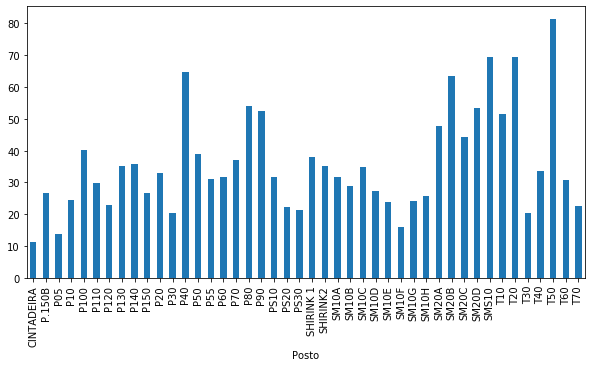

In [29]:
#Graph for referential comparison data
ref.groupby('Posto')['Tempo (s)'].sum().plot(kind="bar", figsize=(10,5))

<h1>Ambiente

In [30]:
def getFirstOperatorsOrder():
    
    order = []
    
    for i in range(0,len(operators.Nome)):
        order = np.append(order, i)
        
    return order

In [2]:
from enums import *
import random

class LayoutSimulation:
    
    def __init__(self, tt=np.max(actions.Time),order = getFirstOperatorsOrder()):

    def take_action(self, action):
        if action == 'INCREASE':
            self.state[0] = self.state[0] + 1
            reward =
        elif action == 'DECREASE':
            self.state[0] = self.state[0] - 1
            reward =
        else:
            aux = self.state[1]
            self.state[1] = self.state[action]
            self.state[action] = aux
            reward = 
            
        return self.state, reward

    def reset(self):
        # Reset state to zero, the beginning of the dungeon
        self.state = np.concatenate(([tt],order))
        return self.state

<h1>Agente

In [1]:
from enums import *
import random
#import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

class DeepAgent:
    def __init__(self, learning_rate=0.5, discount=0.95, exploration_rate=1.0, iterations=10000):
        self.learning_rate = learning_rate
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = exploration_rate # Initial exploration rate
        self.exploration_delta = 1.0 / iterations # Shift from exploration to explotation

        # Input has 43 neurons representing single game state (tt , [order])
        self.input_count = len(operators.Nome) + 1
        
        # Output is 45 neurons, each represents Q-value for action (trade first operator for n-th operator,
        #add 0.1 to tt or decrease 0.1 from tt)
        self.output_count = len(operators.Nome) + 2

        self.session = tf.Session()
        self.define_model()
        self.session.run(self.initializer)

    # Define tensorflow model graph
    def define_model(self):
        # Input is an array of 45 itens (state)
        # Input is 2-dimensional, due to possibility of batched training data
        # NOTE: In this example we assume no batching.
        self.model_input = tf.placeholder(dtype=tf.float32, shape=[None, self.input_count])

        # 8 hidden neurons per layer
        layer_size = 8
        # Two hidden layers of 8 neurons with sigmoid activation initialized to zero for stability
        fc1 = tf.layers.dense(self.model_input, layer_size, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((self.input_count, layer_size))))
        fc2 = tf.layers.dense(fc1, layer_size, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((layer_size, self.output_count))))

        # Output is 43 values, each represents Q-value for action (trade first operator for n-th operator,
        # add 0.1 to tt or decrease 0.1 from tt)
        # Output is 2-dimensional, due to possibility of batched training data
        # NOTE: In this example we assume no batching.
        self.model_output = tf.layers.dense(fc2, self.output_count)

        # This is for feeding training output (a.k.a ideal target values)
        self.target_output = tf.placeholder(shape=[None, self.output_count], dtype=tf.float32)
        # Loss is mean squared difference between current output and ideal target values
        loss = tf.losses.mean_squared_error(self.target_output, self.model_output)
        # Optimizer adjusts weights to minimize loss, with the speed of learning_rate
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(loss)
        # Initializer to set weights to initial values
        self.initializer = tf.global_variables_initializer()

    # Ask model to estimate Q value for specific state (inference)
    def get_Q(self, state):
        # Model input: Single state represented by array of 6 itens(state)
        # Model output: Array of Q values for single state
        #return self.session.run(self.model_output, feed_dict={self.model_input: [[state]]})[0]
        #Definindo tempo total somado das atividades
        total_time = state[0]
        order = state[1:len(state)-1]

        #Definindo a distribuição sequencial baseada em TT e order
        accumulator = 0
        full_time = 0
        time_posto = [0] * len(state)-1
        index = 0
        action_num = 0

        while(action_num < len(actions.Time)-1 and index < len(operators.Nome)):

            while accumulator < tt-actions.Time[action_num]*operators.Eficiencia[order[index]]:
                if(action_num < len(actions.Time)-1):
                    accumulator = accumulator + actions.Time[action_num]*operators.Eficiencia[order[index]]
                    action_num = action_num + 1
                else:
                    break

            time_posto[index] = accumulator 
            full_time = full_time + accumulator
            accumulator = 0
            index = index + 1

        missing_actions = len(actions.Time)-1 - action_num 
        not_working_operators = len(operators.Nome) - np.count_nonzero(time_posto)
        mean_time = time_posto[time_posto!=0].mean()
        max_time = np.max(time_posto)

        if(missing_actions > 0 or not_working_operators > 0):
            return 0
        else:
            return mean_time

    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(state)
        else:
            return self.random_action()

    # Which action has bigger Q-value, estimated by our model (inference).
    def greedy_action(self, state):
        # argmax picks the higher Q-value and returns the index (##TO DEFINE)
        return np.argmax(self.get_Q(state))

    def random_action(self):
        rand = random.randint(0, output_count)
        if(rand == 0):
            return INCREASE
        if(rand == 1):
            return DECREASE
        else:
            return rand

    def train(self, old_state, action, reward, new_state):
        # Ask the model for the Q values of the old state (inference)
        old_state_Q_values = self.get_Q(old_state)

        # Ask the model for the Q values of the new state (inference)
        new_state_Q_values = self.get_Q(new_state)

        # Real Q value for the action we took. This is what we will train towards.
        old_state_Q_values[action] = reward + self.discount * np.amax(new_state_Q_values)
        
        # Setup training data
        training_input = [[old_state]]

        target_output = [old_state_Q_values]
        training_data = {self.model_input: training_input, self.target_output: target_output}

        # Train
        self.session.run(self.optimizer, feed_dict=training_data)

    def update(self, old_state, new_state, action, reward):
        # Train our model with new data
        self.train(old_state, action, reward, new_state)

        # Finally shift our exploration_rate toward zero (less gambling)
        if self.exploration_rate > 0:
            self.exploration_rate -= self.exploration_delta

Instructions for updating:
non-resource variables are not supported in the long term


<h1>Simulação

In [48]:
import random
import json
import argparse
import time

def SimulationStart():
    # parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--learning_rate', type=float, default=0.1, help='How quickly the algorithm tries to learn')
    parser.add_argument('--discount', type=float, default=0.95, help='Discount for estimated future action')
    parser.add_argument('--iterations', type=int, default=2000, help='Iteration count')
    FLAGS, unparsed = parser.parse_known_args()

    agent = DeepAgent()

    # setup simulation
    line_layout = LayoutSimulation()
    line_layout.reset()
    total_reward = 0 # Score keeping

    #Main loop
    for step in range(FLAGS.iterations):
        old_state = line_layout.state # Store current state
        action = agent.get_next_action(old_state) # Query agent for the next action
        new_state, reward = dungeon.take_action(action) # Take action, get new state and reward
        agent.update(old_state, new_state, action, reward) # Let the agent update internals

        total_reward += reward # Keep score
        if step % 250 == 0: # Print out metadata every 100th iteration
            print(json.dumps({'step': step, 'total_reward': total_reward}))

        time.sleep(0.0001) # Avoid spamming stdout too fast!

    print("Final Q-table", agent.q_table)


In [52]:
SimulationStart()

ValueError: Too many elements provided. Needed at most 400, but received 920